# <center>Classifiers for Literacy Standard - Grade 3</center>

Cornell-Farrow and Garrard (2018). A Machine Learning Approach for Detecting Students at Risk of Low Academic Achievement. arXiv preprint. <a href='https://arxiv.org/abs/1807.07215'>arXiv:1807.07215</a>

This notebook contains the code used to generate the classifiers for predicting whether students fall into the 'below standard' band in the numeracy section of NAPLAN for grade 3. IP for this data set is not held by the authors and so may not be uploaded together with this code in order to facilitate reproduction. Instructions for how the data set may be obtained are outlined in the README file.

This notebook was executed on a quadcore Intel i7 2.60GHz cpu with 8GB of RAM. Runtime was about 35 minutes.


## Preprocessing

We begin by loading required packages and importing the data. The data are stored in a Stata .dta file.


In [1]:
library(readstata13)  # Importing data
library(ggplot2)      # Plotting
library(ggthemes)     # Themes for ggplot2
library(caret)        # Create training/test sets
library(rpart)        # Recursive partitioning decision tree classifier
library(rpart.plot)   # Plot the tree
library(pROC)         # Bulding ROC curves
library(DMwR)         # Constructing SMOTE sample
library(glmnet)       # Elastic net classifier
library(randomForest) # Random forest classifier
library(doMC)         # Run elastic net in parallel

start.time <- Sys.time()

# Import data
raw.data <- read.dta13('NAPLAN_data.dta')


Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: grid
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘glmnet’

The following object is masked from ‘package:pROC’:

    auc

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: iterators
Loading required package: parallel


We now summarize the raw data and remove columns not to be used as predictors.

In [2]:
print('Raw data summary.')
dim(raw.data)
summary(raw.data)


# Irrelevant predictors:
# schoolid, studentit, cohort
# readscore and mathscore were used 
# to construct readrisk and mathrisk.
ix <- c(1, 3, 4, 6, 15, 16)
data <- raw.data[, -ix]

# Only retain grade 3
data <- data[which(data$grade == 3), ]
# Remove grade, sameschool, previous scores
data <- data[, -c(2, 11:13)]
data <- data[complete.cases(data), ]

# Remove response variables
readrisk <- data[, 26]
mathrisk <- data[, 27]
data <- data[, -c(26, 27)]

# Attach response variable, make data frame
data <- data.frame(Class=mathrisk, data)


# Summarize data.
print('Preprocessed data summary.')
dim(data)



[1] "Raw data summary."


[1] 2045434      37

    schoolid         priv          studentid            year       
 Min.   :   2   Min.   :0.0000   Min.   :      1   Min.   :0.0000  
 1st Qu.:2309   1st Qu.:0.0000   1st Qu.: 558104   1st Qu.:0.0000  
 Median :4698   Median :0.0000   Median :1117716   Median :0.0000  
 Mean   :4645   Mean   :0.3708   Mean   :1117467   Mean   :0.4999  
 3rd Qu.:6986   3rd Qu.:1.0000   3rd Qu.:1675980   3rd Qu.:1.0000  
 Max.   :9250   Max.   :1.0000   Max.   :2235804   Max.   :1.0000  
 NA's   :1588                    NA's   :1588                      
     grade           cohort           age            indig        
 Min.   :3.000   Min.   :    1   Min.   : 7.00   Min.   :0.00000  
 1st Qu.:3.000   1st Qu.:11346   1st Qu.: 9.20   1st Qu.:0.00000  
 Median :5.000   Median :23157   Median :11.20   Median :0.00000  
 Mean   :5.938   Mean   :22825   Mean   :11.48   Mean   :0.04528  
 3rd Qu.:7.000   3rd Qu.:34286   3rd Qu.:13.30   3rd Qu.:0.00000  
 Max.   :9.000   Max.   :45406   Max.   :17.50   Max. 

[1] "Preprocessed data summary."


[1] 324647     26

Create a data frame with the dummy 'mathrisk' as the response. Currently each variable is coded as a numeric. Turn the categorical/dummy variales into factors.

In [3]:

# Force variable types.
# Numeric types:
# 4, age; 13, readprev; 14, mathprev;
# 27, nstudent, 28, meanreadscore;
# 29, meanmathscore. The rest are 
# factors.
ix.numeric <- c(3, 24:26)
ix.factors <- setdiff(1:dim(data)[2], ix.numeric)

data[, ix.numeric] <- lapply(data[, ix.numeric], as.numeric)
data[, ix.factors] <- lapply(data[, ix.factors], as.factor)

       
# Display variable names and types
sapply(data, class)

# Now Remove raw.data from memory.
rm(list=c('raw.data'))

# Summary
summary(data)


Class          priv           age         indig     mumschool 
     "factor"      "factor"     "numeric"      "factor"      "factor" 
    mumhighed      mumoccup     dadschool     dadhighed      dadoccup 
     "factor"      "factor"      "factor"      "factor"      "factor" 
         girl           met    provincial        remote         lbote 
     "factor"      "factor"      "factor"      "factor"      "factor" 
           SA           NSW           TAS           VIC           QLD 
     "factor"      "factor"      "factor"      "factor"      "factor" 
           WA           ACT            NT      nstudent meanreadscore 
     "factor"      "factor"      "factor"     "numeric"     "numeric" 
meanmathscore 
    "numeric"

 Class      priv            age         indig      mumschool  mumhighed 
 0:318284   0:205801   Min.   : 7.000   0:316904   1: 10474   5: 78376  
 1:  6363   1:118846   1st Qu.: 8.300   1:  7743   2: 41827   6: 51549  
                       Median : 8.600              3: 28599   7:123962  
                       Mean   : 8.586              4:243747   8: 70760  
                       3rd Qu.: 8.800                                   
                       Max.   :10.600                                   
 mumoccup  dadschool  dadhighed  dadoccup  girl       met        provincial
 1:67650   1: 14715   5:111421   1:83641   0:164772   0: 78349   0:251203  
 2:63509   2: 61808   6: 42970   2:84403   1:159875   1:246298   1: 73444  
 3:65601   3: 33685   7:106900   3:80130                                   
 4:37415   4:214439   8: 63356   4:57567                                   
 8:90472                         8:18906                                   
                                 

## Sample splitting

Use a 2/3-1/3 split to obtain training and test sets.


In [4]:
set.seed(2718)

inTrain <- createDataPartition(
  y = data$Class,
  p = 2/3,
  list=F
)

train.data <- data[inTrain, ]
test.data <- data[-inTrain, ]

print('Training data summary')
dim(train.data)
summary(train.data)

print('Test data summary')
dim(test.data)
summary(test.data)


[1] "Training data summary"


[1] 216432     26

 Class      priv            age         indig      mumschool  mumhighed
 0:212190   0:137199   Min.   : 7.000   0:211261   1:  6934   5:52248  
 1:  4242   1: 79233   1st Qu.: 8.300   1:  5171   2: 27834   6:34376  
                       Median : 8.600              3: 19169   7:82738  
                       Mean   : 8.586              4:162495   8:47070  
                       3rd Qu.: 8.800                                  
                       Max.   :10.600                                  
 mumoccup  dadschool  dadhighed dadoccup  girl       met        provincial
 1:45070   1:  9804   5:74005   1:55763   0:109931   0: 52359   0:167332  
 2:42526   2: 41041   6:28601   2:56307   1:106501   1:164073   1: 49100  
 3:43625   3: 22446   7:71460   3:53343                                   
 4:25030   4:143141   8:42366   4:38451                                   
 8:60181                        8:12568                                   
                                              

[1] "Test data summary"


[1] 108215     26

 Class      priv           age         indig      mumschool mumhighed mumoccup 
 0:106094   0:68602   Min.   : 7.000   0:105643   1: 3540   5:26128   1:22580  
 1:  2121   1:39613   1st Qu.: 8.300   1:  2572   2:13993   6:17173   2:20983  
                      Median : 8.600              3: 9430   7:41224   3:21976  
                      Mean   : 8.586              4:81252   8:23690   4:12385  
                      3rd Qu.: 8.800                                  8:30291  
                      Max.   :10.600                                           
 dadschool dadhighed dadoccup  girl      met       provincial remote    
 1: 4911   5:37416   1:27878   0:54841   0:25990   0:83871    0:106569  
 2:20767   6:14369   2:28096   1:53374   1:82225   1:24344    1:  1646  
 3:11239   7:35440   3:26787                                            
 4:71298   8:20990   4:19116                                            
                     8: 6338                                            
  

## Weighted Classifiers

Here we train the weighted classifiers discussed in Section 3 of the paper. 

Let $y_{i} \in \{0, 1\}$ denote the true class for observation $i$, where $y_{i} = 1$ if a student is in the `below standard' category. We construct weights for each observation inversely proportional to the frequency of that observation's class. 
   
\begin{equation}
w_{i} = \frac{1}{2 | \{j : y_{j} = y_{i} \} |}
\end{equation}

glmnet only accepts matrices, not data frames, so we split the data frame into a response vector, y, and a model matrix, X.

In [5]:
# Model weights
train.weights <- ifelse(train.data$Class == 0,
                              (1/table(train.data$Class)[1]*.5),
                              (1/table(train.data$Class)[2]*0.5))

# Turn data frame into matrix
X <- model.matrix(Class ~., train.data)
y <- train.data$Class


### Elastic Net

The elastic net classifier minimizes the following objective function.

\begin{equation}
    \mathcal{L}(\hat{y}_{i}, y_{i}) = w_{i}l(\beta) + \lambda \left( (\alpha ||\beta||_{1} + (1-\alpha)\frac{1}{2} ||\beta||_{2}^{2}\right)
\end{equation}

We impose that the lasso and ridge penalties get equal weight, $\alpha = \frac{1}{2}$, with $\lambda$ being chosen by 10-fold cross-validation.

Passing the argument type.measure="class" to glmnet sets $l(\beta)$ to be the binary cross-entropy loss function.

In [6]:
# Register parallel session
registerDoMC(cores=3)

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
weight.EN.fit <- cv.glmnet(x=X,
                           y=y,
                           family="binomial",
                           alpha=0.5,
                           type.measure="class",
                           weights=train.weights,
                           parallel=T)
Sys.time() - t0


Time difference of 1.962107 mins

Plot the cross-validation curve; display coefficients,confusion matrix and performance measures on the test set.

41 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)    9.4890345218
(Intercept)    .           
priv1          .           
age           -0.0258327556
indig1         0.2383014691
mumschool2     .           
mumschool3     .           
mumschool4    -0.2769238708
mumhighed6     .           
mumhighed7    -0.4646812017
mumhighed8     0.0488559475
mumoccup2      .           
mumoccup3      .           
mumoccup4      .           
mumoccup8      0.0493231003
dadschool2     .           
dadschool3     .           
dadschool4    -0.1961891220
dadhighed6     .           
dadhighed7    -0.3210321640
dadhighed8     0.0586079524
dadoccup2     -0.1054110125
dadoccup3      .           
dadoccup4      0.1408584117
dadoccup8      0.2899004701
girl1         -0.0039624627
met1           .           
provincial1   -0.0074201896
remote1        .           
lbote1         0.0746315656
SA1            .           
NSW1           .           
TAS1           .           
VIC1  

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 76287   529
         1 29807  1592
                                         
               Accuracy : 0.7197         
                 95% CI : (0.717, 0.7223)
    No Information Rate : 0.9804         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0605         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.75059        
            Specificity : 0.71905        
         Pos Pred Value : 0.05070        
         Neg Pred Value : 0.99311        
             Prevalence : 0.01960        
         Detection Rate : 0.01471        
   Detection Prevalence : 0.29015        
      Balanced Accuracy : 0.73482        
                                         
       'Positive' Class : 1              
                                         

Sensitivity          Specificity       Pos Pred Value 
           75.058934            71.905103             5.070225 
      Neg Pred Value            Precision               Recall 
           99.311341             5.070225            75.058934 
                  F1           Prevalence       Detection Rate 
            9.498807             1.959987             1.471145 
Detection Prevalence    Balanced Accuracy 
           29.015386            73.482019

[1] "AUC"


Area under the curve: 0.8107

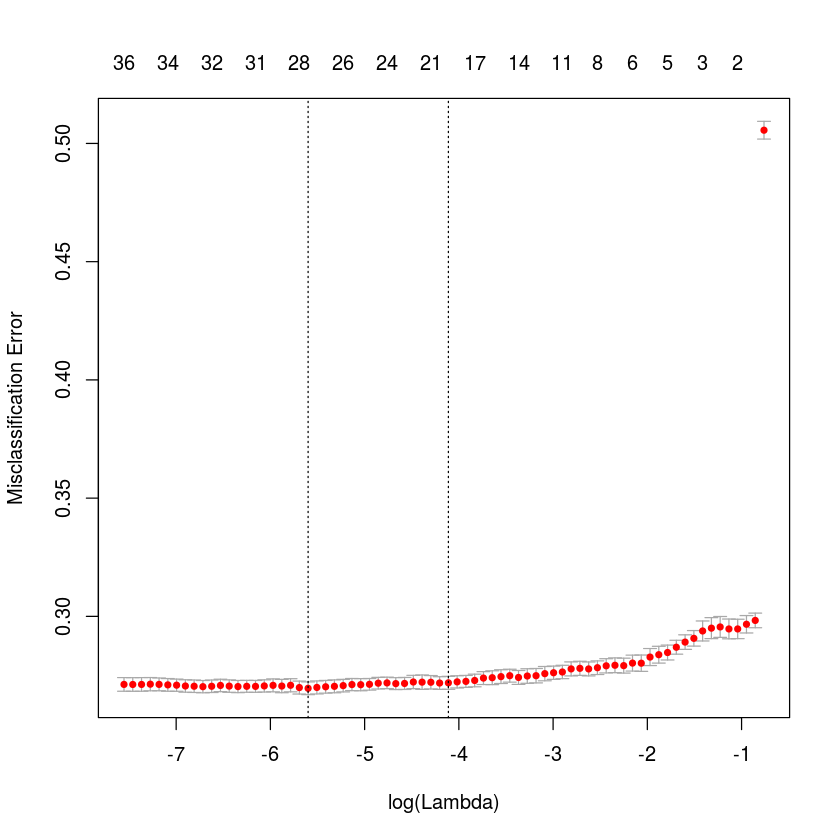

In [7]:
# Cross-validation curve
plot(weight.EN.fit)

# Estimated coefficients
coef(weight.EN.fit, s='lambda.1se')

# Confusion matrix
weight.EN.preds <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
weight.EN.CM <- confusionMatrix(as.factor(weight.EN.preds), test.data[, 1], positive=c('1'))
weight.EN.CM

# Sensitivity/specificity/precision/F1/accuracy
weight.EN.CM$byClass*100

# ROC curve
weight.EN.probs <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
weight.EN.roc <- roc(test.data[, 1], as.numeric(weight.EN.probs))

# Display area under the ROC curve
print('AUC')
weight.EN.roc$auc



### Classification Tree

Train a recursive partitioning tree using rpart.

In [8]:
t0 <- Sys.time()
weight.cart.fit <- rpart(Class ~.,
                         data=train.data,
                         weights = train.weights)
t1 <- Sys.time() - t0
t1

Time difference of 11.78143 secs

Show confusion matrix for test set, performance metrics, and plot the tree.

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 77038   615
         1 29056  1506
                                          
               Accuracy : 0.7258          
                 95% CI : (0.7231, 0.7285)
    No Information Rate : 0.9804          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0576          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.71004         
            Specificity : 0.72613         
         Pos Pred Value : 0.04928         
         Neg Pred Value : 0.99208         
             Prevalence : 0.01960         
         Detection Rate : 0.01392         
   Detection Prevalence : 0.28242         
      Balanced Accuracy : 0.71809         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           71.004243            72.612966             4.927688 
      Neg Pred Value            Precision               Recall 
           99.208015             4.927688            71.004243 
                  F1           Prevalence       Detection Rate 
            9.215800             1.959987             1.391674 
Detection Prevalence    Balanced Accuracy 
           28.241926            71.808605

[1] "AUC"


Area under the curve: 0.7181

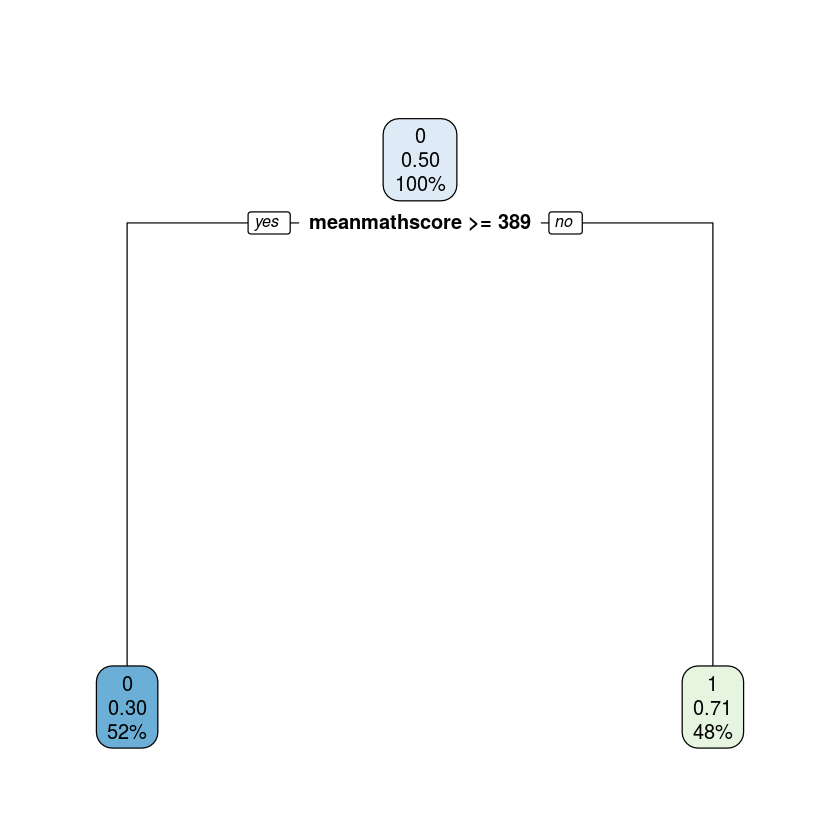

In [9]:
# Confusion matrix
weight.cart.preds <- predict(weight.cart.fit, newdata=test.data[, -1], type='class')
weight.cart.CM <- confusionMatrix(weight.cart.preds, test.data[, 1], positive="1")
weight.cart.CM
weight.cart.CM$byClass*100

# ROC curve
weight.oos.probs <- predict(weight.cart.fit, newdata=test.data[, -1])[, 2]
weight.roc <- roc(test.data[, 1], weight.oos.probs)
print('AUC')
weight.roc$auc


# Plot the tree
rpart.plot(weight.cart.fit,
           cex=1,
           fallen.leaves=T)


## SMOTE Classifiers

We balance the training set by generating a SMOTE sample using the out-of-the-box settings.

In [10]:
# Generate SMOTE sample
SMOTE.data <- SMOTE(Class ~., train.data)
dim(SMOTE.data)
summary(SMOTE.data)

# Turn into matrices
X <- model.matrix(Class ~., SMOTE.data)
y <- SMOTE.data$Class

[1] 29694    26

 Class     priv           age         indig     mumschool mumhighed mumoccup
 0:16968   0:18346   Min.   : 7.000   0:25697   1: 2708   5:8016    1:4649  
 1:12726   1:11348   1st Qu.: 8.300   1: 3997   2: 5452   6:4329    2:5023  
                     Median : 8.505             3: 3395   7:8092    3:5815  
                     Mean   : 8.554             4:18139   8:9257    4:4465  
                     3rd Qu.: 8.800                                 8:9742  
                     Max.   :10.500                                         
 dadschool dadhighed dadoccup girl      met       provincial remote   
 1: 3038   5:10755   1:5566   0:15080   0:10441   0:21720    0:27254  
 2: 7046   6: 3609   2:6404   1:14614   1:19253   1: 7974    1: 2440  
 3: 3359   7: 7010   3:7274                                           
 4:16251   8: 8320   4:7016                                           
                     8:3434                                           
                                   

### Elastic Net (SMOTE)

Now run the elastic net and tree, but without class weights this time.

In [11]:

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
SMOTE.EN.fit <- cv.glmnet(x=X,
                          y=y,
                          family="binomial",
                          alpha=0.5,
                          type.measure="class",
                        parallel=T)
Sys.time() - t0

Time difference of 12.0983 secs

Display coefficients, CV curve, confusion matrix, performance measures.

41 x 1 sparse Matrix of class "dgCMatrix"
                         1
(Intercept)   10.604282050
(Intercept)    .          
priv1          0.261536087
age           -0.025626661
indig1         1.443028929
mumschool2     .          
mumschool3     .          
mumschool4    -0.469727282
mumhighed6     .          
mumhighed7    -0.368163191
mumhighed8     0.105199892
mumoccup2      .          
mumoccup3     -0.062802332
mumoccup4      .          
mumoccup8      .          
dadschool2     .          
dadschool3     .          
dadschool4    -0.349276306
dadhighed6     .          
dadhighed7    -0.071410959
dadhighed8     0.195935886
dadoccup2     -0.066042224
dadoccup3      .          
dadoccup4      0.137074754
dadoccup8      0.398297865
girl1          .          
met1          -0.248522683
provincial1    .          
remote1        0.691900355
lbote1         0.553952499
SA1            .          
NSW1           .          
TAS1           .          
VIC1          -0.139716093
QLD1         

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 92148   986
         1 13946  1135
                                          
               Accuracy : 0.862           
                 95% CI : (0.8599, 0.8641)
    No Information Rate : 0.9804          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1011          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.53512         
            Specificity : 0.86855         
         Pos Pred Value : 0.07526         
         Neg Pred Value : 0.98941         
             Prevalence : 0.01960         
         Detection Rate : 0.01049         
   Detection Prevalence : 0.13936         
      Balanced Accuracy : 0.70184         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           53.512494            86.855053             7.526026 
      Neg Pred Value            Precision               Recall 
           98.941310             7.526026            53.512494 
                  F1           Prevalence       Detection Rate 
           13.196140             1.959987             1.048838 
Detection Prevalence    Balanced Accuracy 
           13.936146            70.183774

[1] "AUC"


Area under the curve: 0.8036

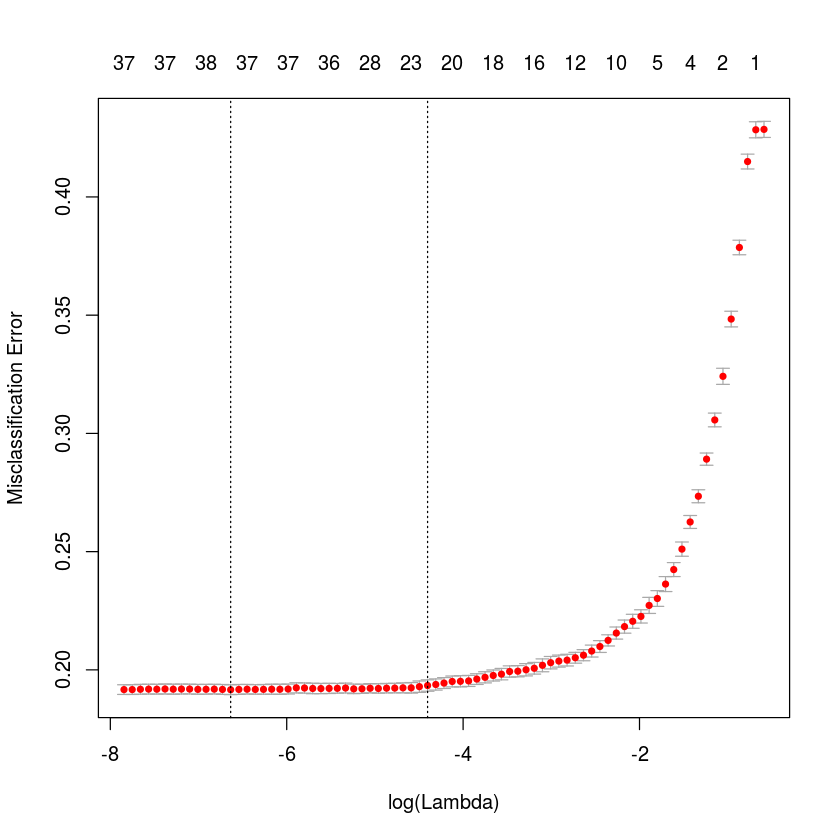

In [12]:
# Coefficients
coef(SMOTE.EN.fit, s='lambda.1se')

# Confusion matrix
SMOTE.EN.preds <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
SMOTE.EN.CM <- confusionMatrix(as.factor(SMOTE.EN.preds), test.data[, 1], positive=c('1'))
SMOTE.EN.CM
SMOTE.EN.CM$byClass*100

# ROC curve
SMOTE.EN.probs <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
SMOTE.EN.roc <- roc(test.data[, 1], as.numeric(SMOTE.EN.probs))

print('AUC')
SMOTE.EN.roc$auc

# CV curve
plot(SMOTE.EN.fit)


### Decision Tree (SMOTE)


In [13]:
t0 <- Sys.time()
SMOTE.cart.fit <- rpart(Class ~.,
                    data=SMOTE.data)
t1 <- Sys.time() - t0
t1


Time difference of 1.718068 secs

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 91302   970
         1 14792  1151
                                          
               Accuracy : 0.8543          
                 95% CI : (0.8522, 0.8564)
    No Information Rate : 0.9804          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0962          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.54267         
            Specificity : 0.86058         
         Pos Pred Value : 0.07219         
         Neg Pred Value : 0.98949         
             Prevalence : 0.01960         
         Detection Rate : 0.01064         
   Detection Prevalence : 0.14733         
      Balanced Accuracy : 0.70162         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           54.266855            86.057647             7.219469 
      Neg Pred Value            Precision               Recall 
           98.948760             7.219469            54.266855 
                  F1           Prevalence       Detection Rate 
           12.743578             1.959987             1.063623 
Detection Prevalence    Balanced Accuracy 
           14.732708            70.162251

[1] "AUC"


Area under the curve: 0.7391

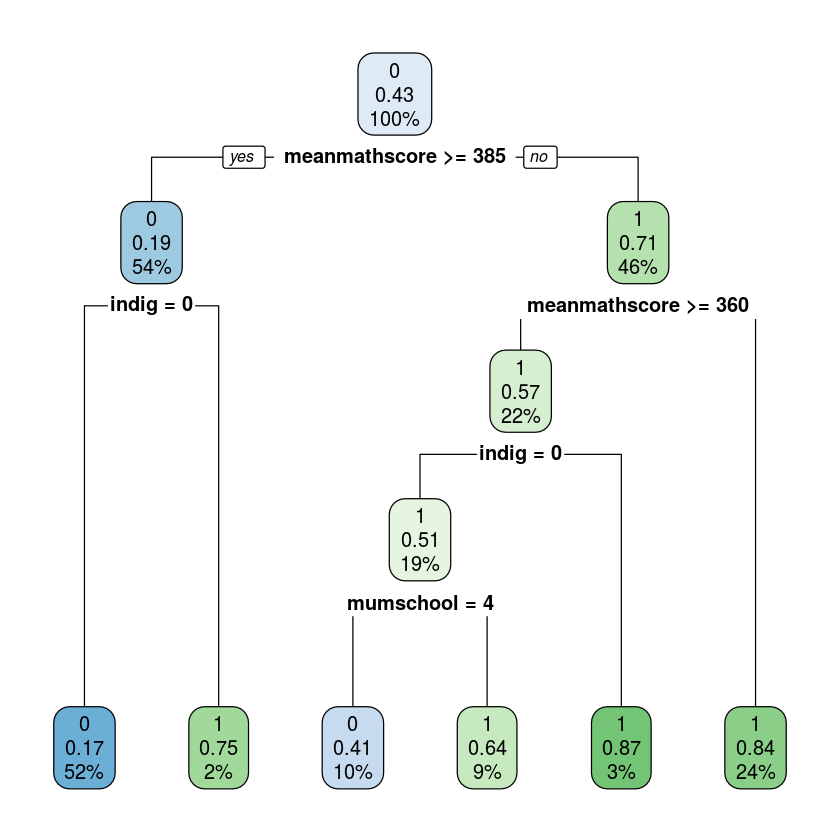

In [14]:
# Confusion Matrix
SMOTE.cart.preds <- predict(SMOTE.cart.fit, newdata=test.data[, -1], type='class')
SMOTE.cart.CM <- confusionMatrix(SMOTE.cart.preds, test.data[, 1], positive="1")
SMOTE.cart.CM
SMOTE.cart.CM$byClass*100

# ROC curve
SMOTE.cart.oos.probs <- predict(SMOTE.cart.fit, newdata=test.data[, -1])[, 2]
SMOTE.cart.roc <- roc(test.data[, 1], SMOTE.cart.oos.probs)
print("AUC")
SMOTE.cart.roc$auc

# Plot tree
rpart.plot(SMOTE.cart.fit,
           cex=1,
           fallen.leaves=T)


## Random Forest (SMOTE)

Now let's train a random forest on the SMOTE sample. Use an ensemble of 200 trees.



In [15]:
t0 <- Sys.time()
set.seed(2718)
rf.fit <- randomForest(x=X,
                       y=y,
                       ntree = 200)
Sys.time() - t0


Time difference of 31.89176 secs

png 
  2

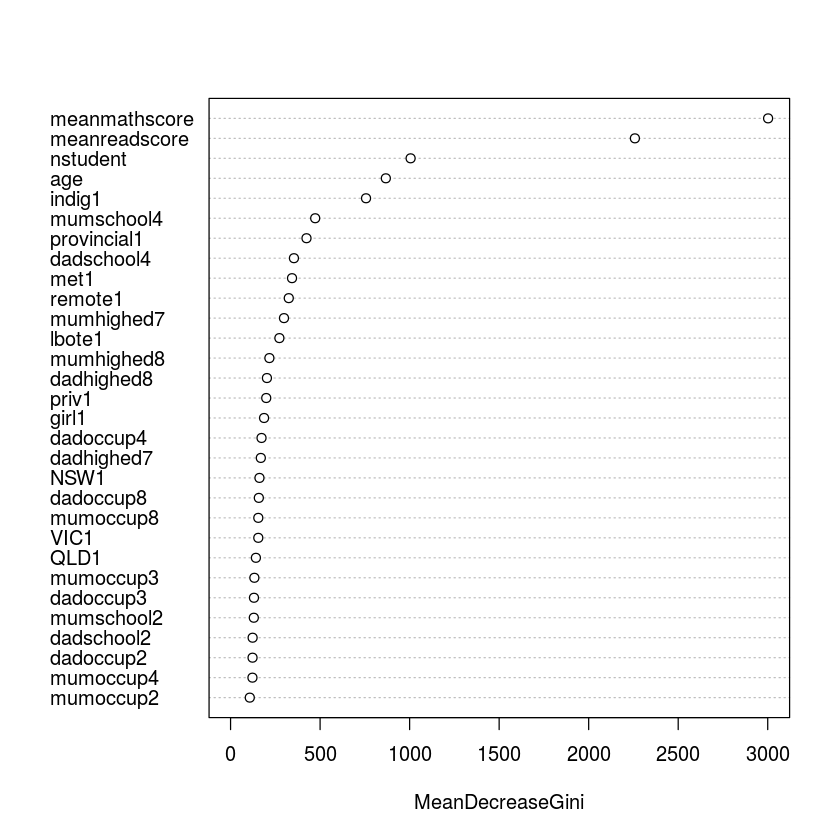

In [16]:
setEPS()
postscript("RF_varimp_Num_G3.eps", fonts=c('serif'))
varImpPlot(rf.fit, type=2, main="")
dev.off()

varImpPlot(rf.fit, type=2, main="")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 93538  1083
         1 12556  1038
                                         
               Accuracy : 0.874          
                 95% CI : (0.872, 0.8759)
    No Information Rate : 0.9804         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1016         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.489392       
            Specificity : 0.881652       
         Pos Pred Value : 0.076357       
         Neg Pred Value : 0.988554       
             Prevalence : 0.019600       
         Detection Rate : 0.009592       
   Detection Prevalence : 0.125620       
      Balanced Accuracy : 0.685522       
                                         
       'Positive' Class : 1              
                                         

Sensitivity          Specificity       Pos Pred Value 
          48.9391796           88.1652120            7.6357216 
      Neg Pred Value            Precision               Recall 
          98.8554338            7.6357216           48.9391796 
                  F1           Prevalence       Detection Rate 
          13.2103086            1.9599871            0.9592016 
Detection Prevalence    Balanced Accuracy 
          12.5620293           68.5521958

[1] "AUC"


Area under the curve: 0.7987

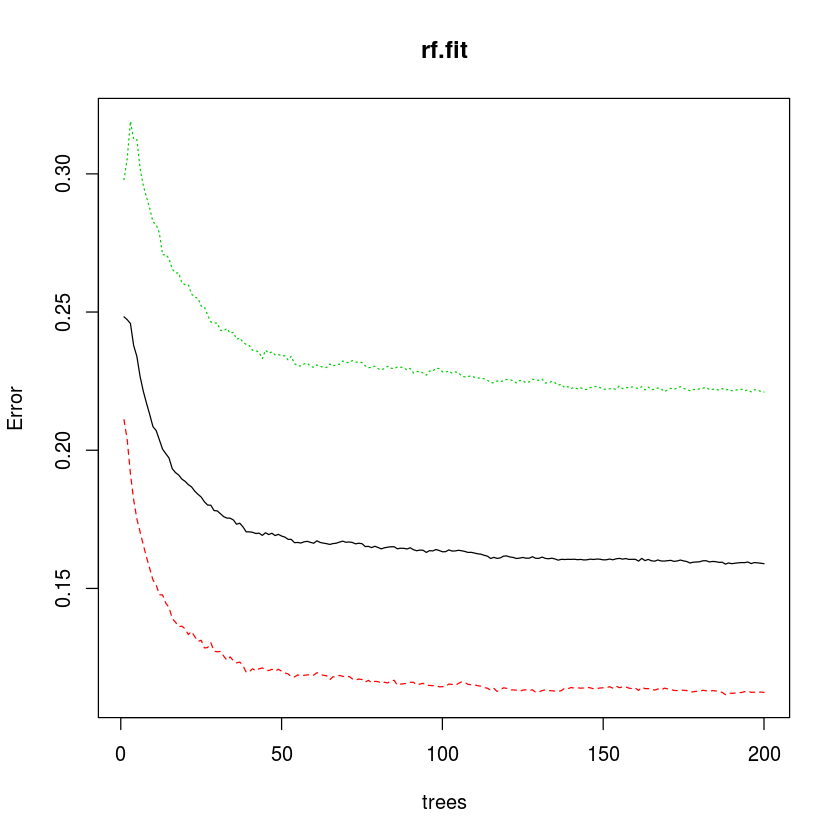

In [17]:
# Confusion matrix
rf.preds <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='class')
rf.CM <- confusionMatrix(rf.preds, test.data[, 1], positive="1")
rf.CM
rf.CM$byClass*100

# ROC curve
SMOTE.rf.oos.probs <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='prob')[, 2]
SMOTE.rf.roc <- roc(test.data[, 1], SMOTE.rf.oos.probs)
print("AUC")
SMOTE.rf.roc$auc

# Plot the random forest training curves
plot(rf.fit)


## ROC Curves

We've saved the individual ROC curves for each of the 5 classifiers. Let's plot them all together on the one graph. First get all the data together in a data frame for ggplot2.

In [18]:
weight.EN.roc.df <- data.frame(Sens=weight.EN.roc$sensitivities, Spec=weight.EN.roc$specificities, Classifier='Weighted EN')
weight.roc.df <- data.frame(Sens=weight.roc$sensitivities, Spec=weight.roc$specificities, Classifier='Weighted Tree')
SMOTE.EN.roc.df <- data.frame(Sens=SMOTE.EN.roc$sensitivities, Spec=SMOTE.EN.roc$specificities, Classifier='SMOTE EN')
SMOTE.cart.roc.df <- data.frame(Sens=SMOTE.cart.roc$sensitivities, Spec=SMOTE.cart.roc$specificities, Classifier='SMOTE Tree')
SMOTE.rf.roc.df <- data.frame(Sens=SMOTE.rf.roc$sensitivities, Spec=SMOTE.rf.roc$specificities, Classifier='SMOTE RF')


# For some reason the Elastic Net ROC curves have a huge number of data points.
# Down sample them in order to plot the ROC curve
ix <- sample(nrow(weight.EN.roc.df), 50, replace = F)
weight.EN.roc.df <- weight.EN.roc.df[ix, ]
ix <- sample(nrow(SMOTE.EN.roc.df), 50, replace = F)
SMOTE.EN.roc.df <- SMOTE.EN.roc.df[ix, ]

all.rocs <- rbind(weight.EN.roc.df,
                  weight.roc.df,
                  SMOTE.EN.roc.df,
                  SMOTE.cart.roc.df,
                  SMOTE.rf.roc.df)


Now plot the curves.

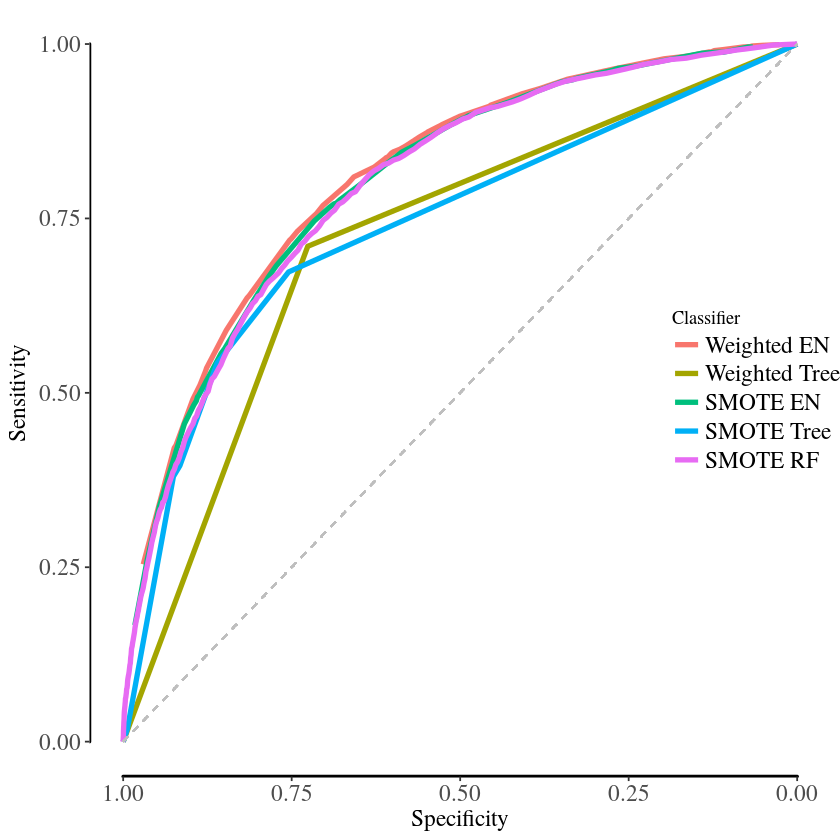

In [19]:
ROC2 <- ggplot(data=all.rocs, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity', cex=1.5)+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=14),
         axis.text.y = element_text(size=14),
         axis.title = element_text(size=14),
         legend.text = element_text(size=14),
         legend.position = c(.9, .5))  
ROC2

## Cleaning Up

Let's put the relevant outputs into a clean form so that they can be copied into the paper. 

Start by saving our decision trees and ROC curve to disk in postscript format.


In [20]:
# Weighted tree
setEPS()
postscript("G3Num_Weighted_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(weight.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

# Smote tree
setEPS()
postscript("G3Num_Smote_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(SMOTE.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

setEPS()
postscript("G3ROC_Num.eps", fonts=c('serif'))
ROC2
dev.off()

png 
  2

png 
  2

png 
  2

Next, we'll prep the elastic net coefficients. We want a LaTeX table with five columns: 1) variable names; 2)literacy/weighted coefficients; 3) literacy SMOTE coefs; 4) numeracy weighted; 5) numeracy SMOTE.

Let's stick the variable names, literacy weighted, and literacy SMOTE data into a data frame which we can load when the numeracy results are finished. Then we'll save the whole thing in one LaTeX table.

In [21]:
library(xtable) # LaTeX tables

# Weighted EN
Cw <- coef(weight.EN.fit)

# Round the coefficients to 2SF.
Cw <- round(Cw[, 1], 2)

# SMOTE EN
Cs <- coef(SMOTE.EN.fit)
Cs <- round(Cs[, 1], 2)

temp <- data.frame(Weighted=Cw, SMOTE=Cs)

# Note that there are two instances of 'intercept'. 
# Remove the second.
temp <- temp[-2, ]

# Now load the coefficients for literacy (EN)
load('G3ElasticNetCoefs.Rda')

# Bind them together
EN <- cbind(EN, temp)

tab1 <- xtable(EN,
              align='ll|cccc',
              caption='Estimated coefficients for elastic net classifiers.',
              label='tab:CoefsEN')

# Export to .tex file
print(tab1, include.rownames=F)
write.table(print(tab1, include.rownames=F), 'G3CoefsEN.tex')


% latex table generated in R 3.4.4 by xtable 1.8-2 package
% Thu Jul 12 15:17:35 2018
\begin{table}[ht]
\centering
\begin{tabular}{l|cccc}
  \hline
Variable & Weighted & SMOTE & Weighted & SMOTE \\ 
  \hline
(Intercept) & 8.23 & 9.39 & 9.49 & 10.60 \\ 
  priv1 & 0.00 & 0.38 & 0.00 & 0.26 \\ 
  age & 0.00 & 0.00 & -0.03 & -0.03 \\ 
  indig1 & 0.24 & 1.79 & 0.24 & 1.44 \\ 
  mumschool2 & 0.00 & -0.06 & 0.00 & 0.00 \\ 
  mumschool3 & 0.00 & -0.12 & 0.00 & 0.00 \\ 
  mumschool4 & -0.28 & -0.62 & -0.28 & -0.47 \\ 
  mumhighed6 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  mumhighed7 & -0.41 & -0.30 & -0.46 & -0.37 \\ 
  mumhighed8 & 0.03 & 0.10 & 0.05 & 0.11 \\ 
  mumoccup2 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  mumoccup3 & 0.00 & -0.03 & 0.00 & -0.06 \\ 
  mumoccup4 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  mumoccup8 & 0.00 & 0.00 & 0.05 & 0.00 \\ 
  dadschool2 & 0.00 & -0.12 & 0.00 & 0.00 \\ 
  dadschool3 & 0.00 & -0.21 & 0.00 & 0.00 \\ 
  dadschool4 & -0.25 & -0.47 & -0.20 & -0.35 \\ 
  dadhighed6 & 0.00 & 0.00 

Finally, let's save our workspace.

In [22]:
save.image('literacy_workspace_Grade_3.RData')
print('Finished.') 
Sys.time() - start.time

[1] "Finished."


Time difference of 3.947851 mins